# <h1 style="text-align: center;"><b>Language modeling</b> 



    

    Language modeling is the task of predicting the next word in a text.
    Given a sequence of words w_1, w_2, ..., w_t estimate the probability for the next word w_(t+1)
    where w_(t+1) can be any word in a predefined vocabulary V. It can be viewed as a classification task, 
    since it predicts a word from a limited set of words, V.

$$ P ( w_{t+1} | w_1, w_2, ..., w_{t} ) $$




    A system that performs this task is called  ** Language Model **.
    Language models (LMs) estimate a conditional probability distribution of the next word, given the words seen so far.

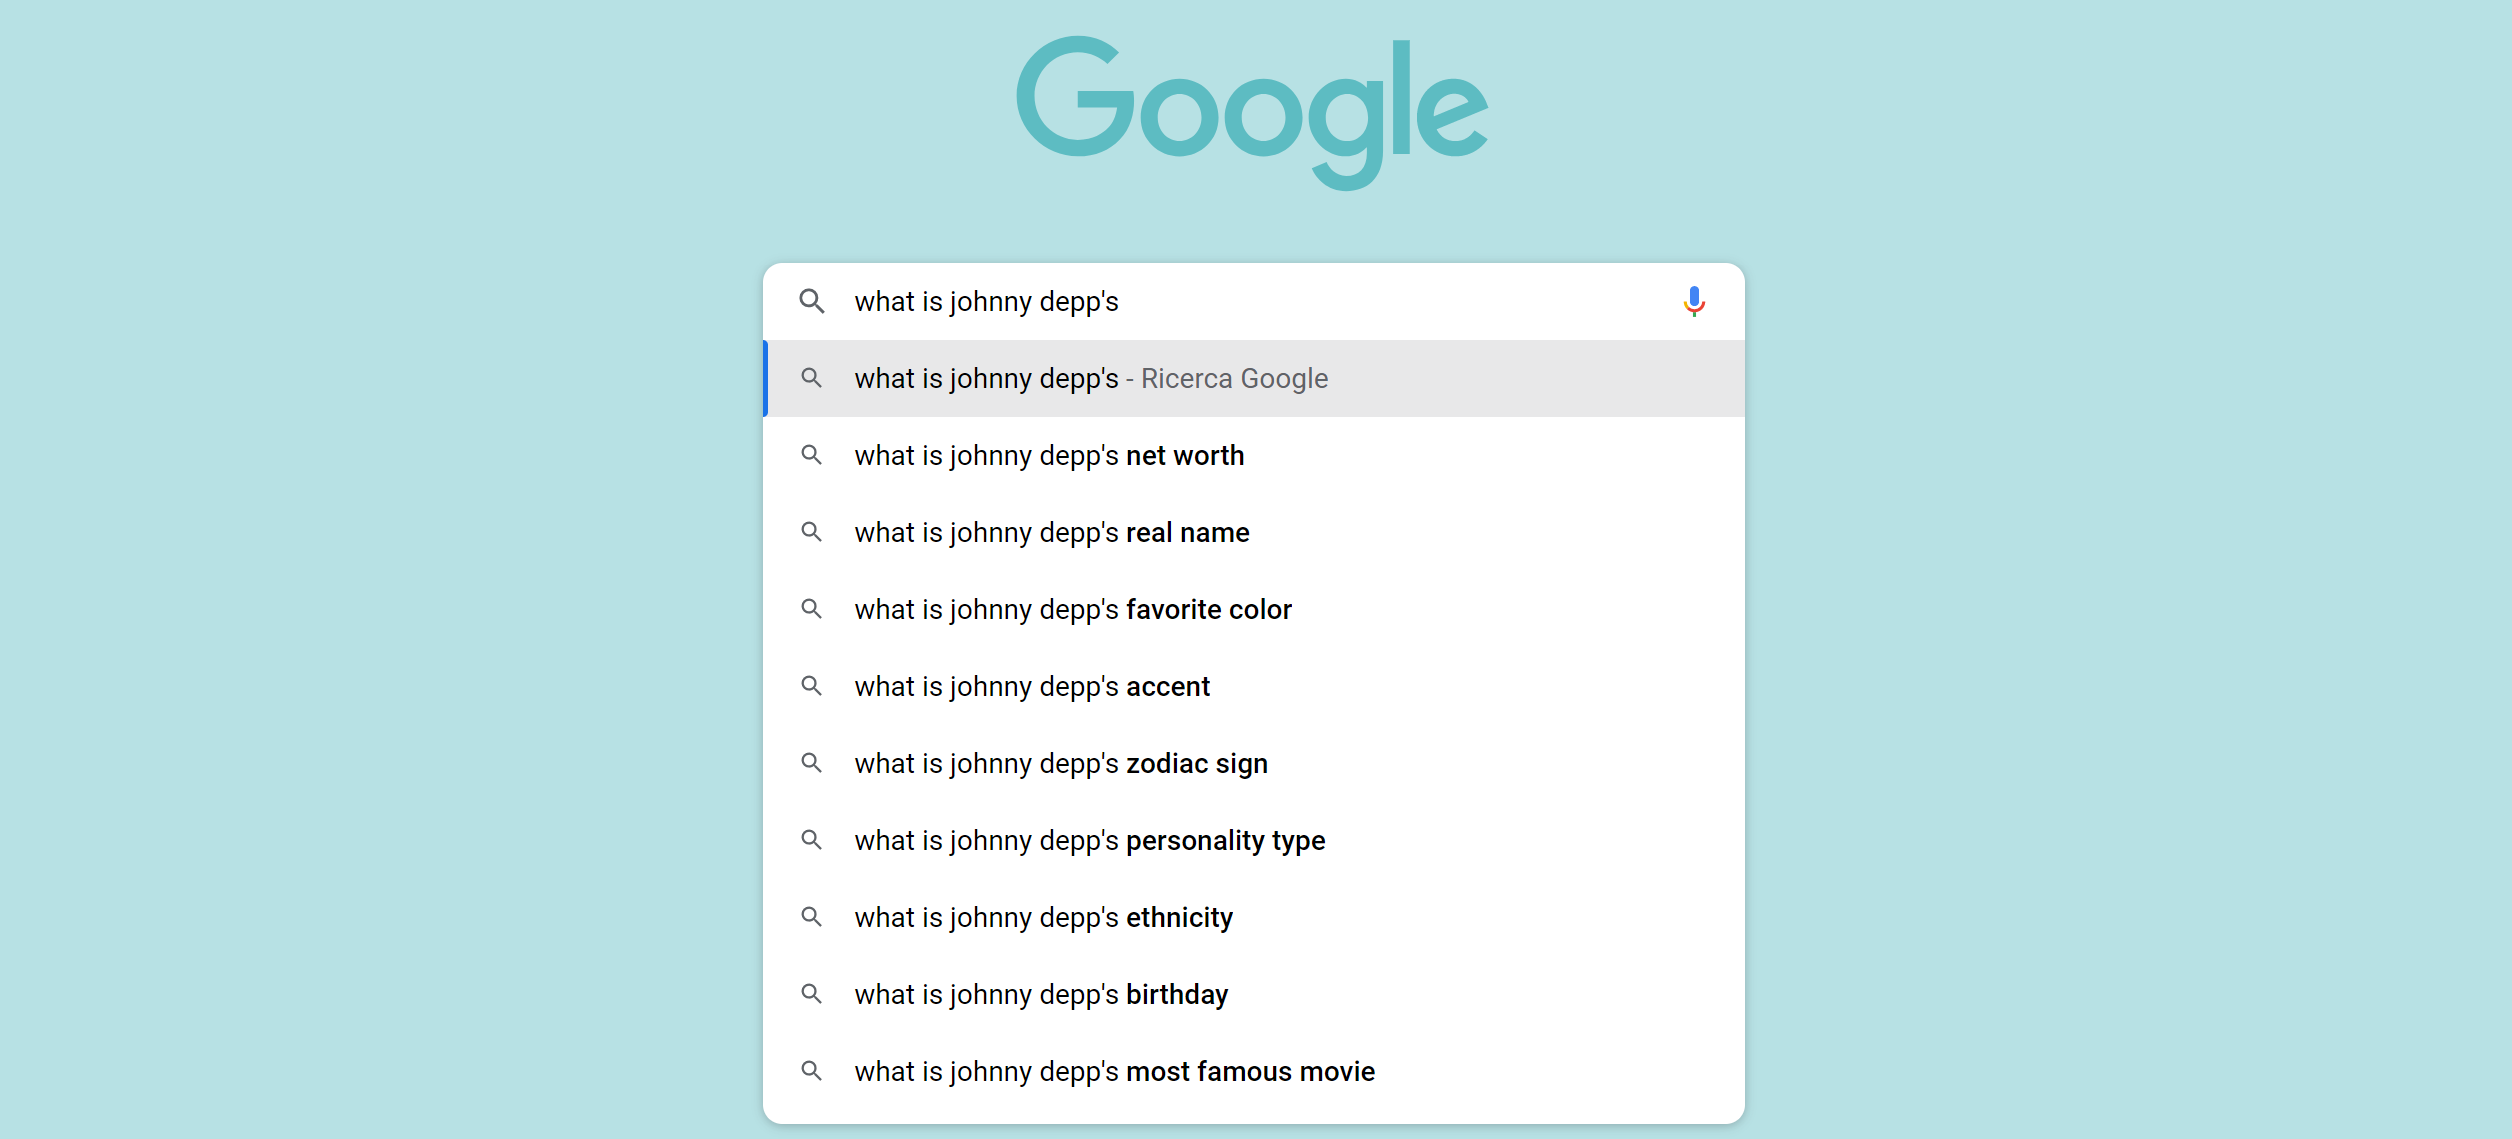

       A language model can be used to assign probability to a piece of text, a sentence for instance.
       It estimates the probability of a sequence of words by computing product of conditional probabilities.


$$ P(\text{ Time flies like an arrow} ) 
= P(\text{ Time } ) · P(\text{ flies }|\text{ Time } ) · P(\text{ like }| \text{ Time flies }) · P(\text{ an } | \text{ Time flies like } ) · P(\text{ arrow } | \text{ Time flies like an } ) $$



    Question: How does the model estimate these conditional probabilities ?  



# <h2 style="text-align: center;"><b>N-gram Language Model</b>
       

    A n-gram is a chunk of consecutive words.
    
    * unigrams:  time, flies, like, an, arrow
    * bigrams:   (time, flies), (flies, like), (like, an), (an, arrow)
    * trigrams:  (time, flies, like), (flies, like, an), (like, an, arrow)
    * 4-grams:   (time, flies, like, an), (flies, like, an, arrow)



    N-gram language model estimates conditional probability of the next word
    by collecting n-gram counts from a text corpus.

$$ P(w_{t+1}| w_1, .., w_{t} ) = \frac{count (w_1, .., w_{t}, w_{t+1})}{count( w_1, .., w_{t})}  $$


#### Simplifying assumption
    The n-gram model assumes that the probability of a word (gram) depends only on preceding n - 1 words.
    A 3-gram language model approximates conditional probabilities as follows:

$$ P(\text{ Time flies like an arrow} ) 
= P(\text{ Time } ) · P(\text{ flies }|\text{ Time } ) · P(\text{ like }| \text{ Time flies }) · P(\text{ an } | \text{  flies like } ) · P(\text{ arrow } | \text{ like an } ) $$


#### Smoothing and backoff
    Cases of zeros at denominator or numerator: 
    * Avoid zeros in the numerator, by adding 1, or some small quantity to all ngram counts. (laplace smoothing)
      Smoothing is used to give some probability to unseen ngrams.  
    * If a prefix has not been observed, a zero at denominator will prevent you from computing the probability:
      the only solution is to backoff to shorter ngram prefix.



# <h2 style="text-align: center;"><b> Neural Language Model </b>
 


    Neural LMs train a network to predict conditional probabilities of a token given its context.
    * encode the context (previous words) into a vector representation
    * predict the probability distribution for the next token from this representation 

    A neural LM can be seen as a classifier: 
    the number of classes is equal to the number of words in the vocabulary.

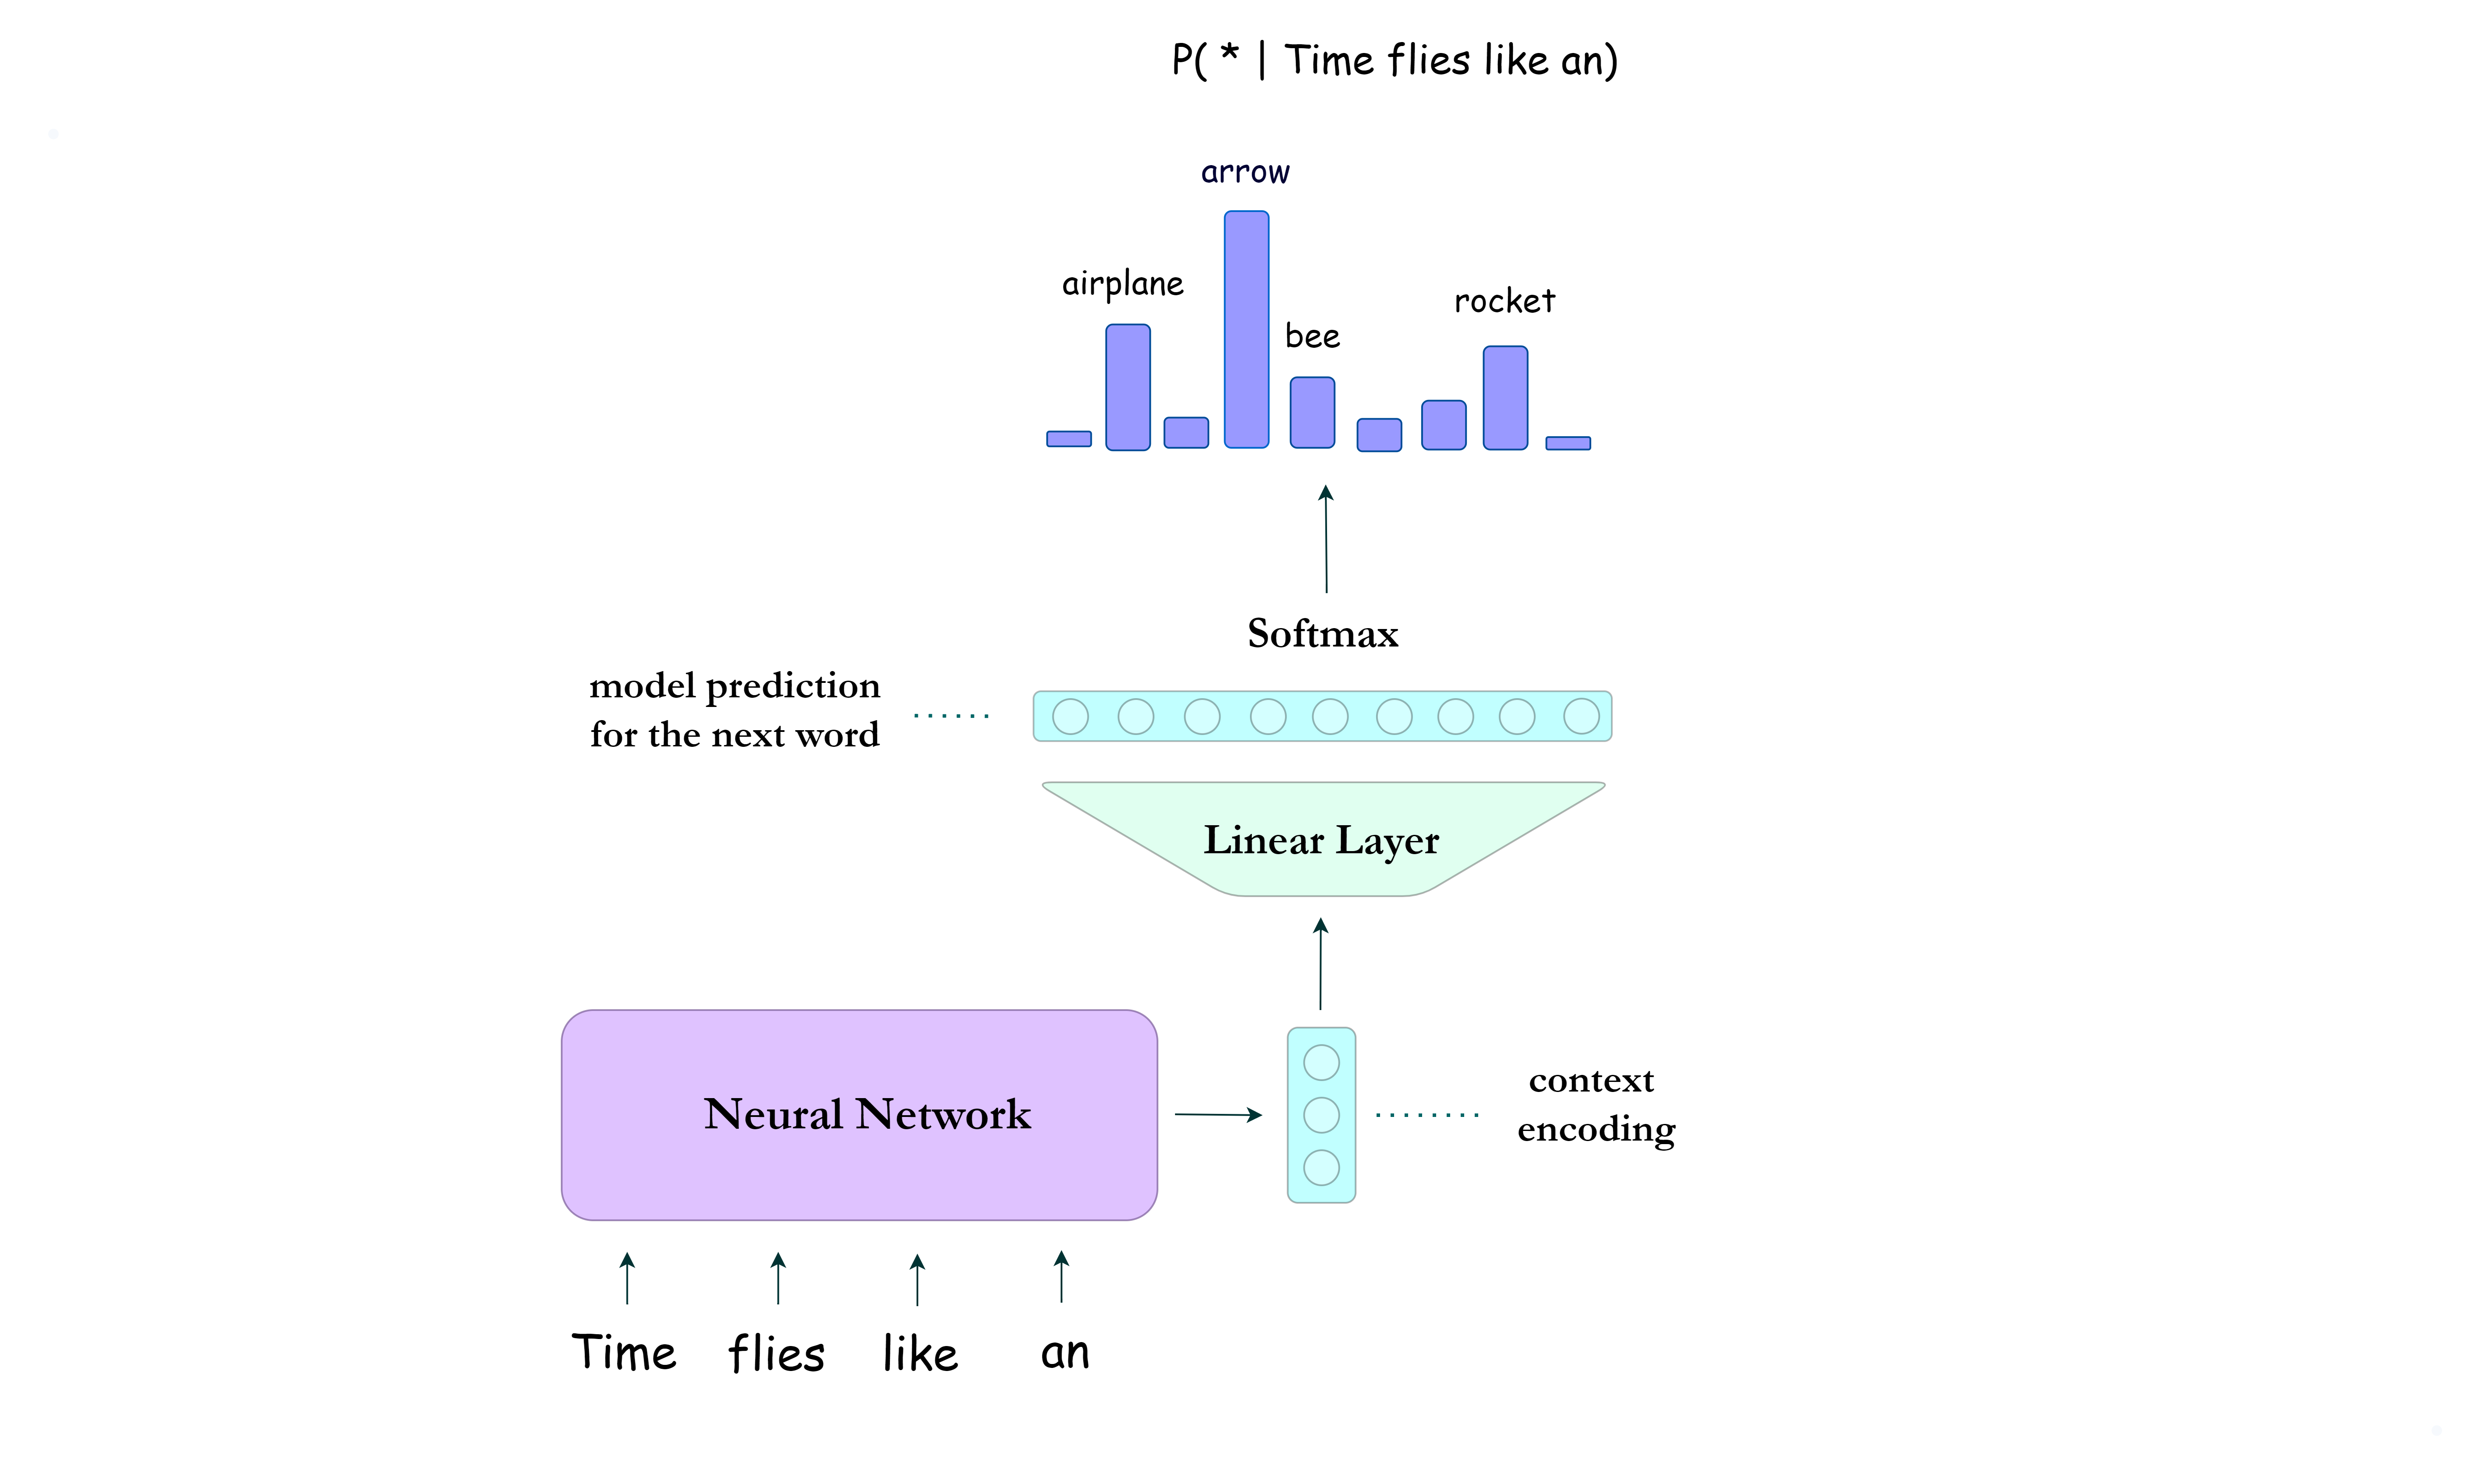

### How can we generate text with a LM ?
    * step 0: start with some context, i.e. a sequence of words (called prefix)
    * step 1: predict the probability distribution for the next token over the vocabulary terms
    * step 2: sample a word from the model distribution
    * step 4: extend the prefix with a new word 
    * step 5: repeat the previous steps

##  Model Shakespeare characters' language

    Our corpus consists of 40,000 lines from a variety of Shakespeare's plays.

In [4]:
import numpy as np
import re, nltk
from tqdm.notebook import tqdm
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import defaultdict, Counter, OrderedDict
from torchtext.vocab import vocab

nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dashb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
with open(r"C:\Users\dashb\Downloads\Telegram Desktop\shakespeare_tiny.txt") as file:
    plays = file.read()
    
print(plays[522001:522700])


Yet 'banished'? Hang up philosophy!
Unless philosophy can make a Juliet,
Displant a town, reverse a prince's doom,
It helps not, it prevails not: talk no more.

FRIAR LAURENCE:
O, then I see that madmen have no ears.

ROMEO:
How should they, when that wise men have no eyes?

FRIAR LAURENCE:
Let me dispute with thee of thy estate.

ROMEO:
Thou canst not speak of that thou dost not feel:
Wert thou as young as I, Juliet thy love,
An hour but married, Tybalt murdered,
Doting like me and like me banished,
Then mightst thou speak, then mightst thou tear thy hair,
And fall upon the ground, as I do now,
Taking the measure of an unmade grave.

FRIAR LAURENCE:
Arise; one knocks; good Romeo, hide thy


    Retrieve names for all characters appearing in the corpus.

In [6]:
characters = defaultdict(int)

for reply in plays.split("\n\n"):
    match = re.search(r"[A-Z]\w+( \w+)*:\n", reply)
    if match is not None:
        characters[match.group(0).strip(":\n")] += 1
        
characters = [name for name, freq in sorted(characters.items(), key=lambda x: x[1], reverse=True)]
print("Number of charaters in the dataset:", len(characters))
print("Names of the first 8 main characters in the Shakespeare plays:\n", characters[:8])

Number of charaters in the dataset: 271
Names of the first 8 main characters in the Shakespeare plays:
 ['GLOUCESTER', 'DUKE VINCENTIO', 'MENENIUS', 'ROMEO', 'CORIOLANUS', 'KING RICHARD III', 'ISABELLA', 'JULIET']


## <h5 style="text-align: center;"><b>Data preparation</b>

    We split corpus into sentences using ``nltk.tokenize_sentence`` and filter for sentences longer than 3 tokens.
    Sentences are tokenized with the help of ``nltk.tokenize_word`` and <eos> token is appended at the end of each sentence.


In [7]:
def tokenize_sentence(sentence):
    """ Clean and tokenize the sentence. """
    clean_sentence = re.sub("--", " ", sentence.strip())
    tokens = word_tokenize(clean_sentence)
    return tokens

In [55]:
sentences = []

for sentence in sent_tokenize(re.sub("\n", " ", plays)):
    tokenized_sent = tokenize_sentence(sentence.lower())
    if len(tokenized_sent) < 3:
        continue
    sentences.append(tokenized_sent + ["<eos>"])
    
print("Total number of training sentences: ", len(sentences))

Total number of training sentences:  10882


In [56]:
# example of the first sentence after tokenization
print(" ".join(sentences[0]))

first citizen : before we proceed any further , hear me speak . <eos>


## <h3 style="text-align: center;"><b>N-Gram modeling</b>

In [10]:
from nltk import bigrams, trigrams, ngrams

In [11]:
list(ngrams("Hear me speek .".split(), n=3 , pad_left=True))

[(None, None, 'Hear'),
 (None, 'Hear', 'me'),
 ('Hear', 'me', 'speek'),
 ('me', 'speek', '.')]

In [33]:
# build a trigram model

model = defaultdict(Counter)
for sentence in sentences:
    for w1, w2, w3 in ngrams(sentence, n=3, pad_left=True):
        model[(w1, w2)][w3] += 1

In [14]:
print(f"'juliet' follows 'romeo' : {model['romeo', ':']['juliet']} times")
print(f" {model[None, None]['juliet']} sentences start with 'juliet' ")

'juliet' follows 'romeo' : 2 times
 118 sentences start with 'juliet' 


In [34]:
# compute probabilities from counts

for w1_w2 in model:
    w1_w2_total_counts = float(sum(model[w1_w2].values()))
    for w3 in model[w1_w2]:
        probability = model[w1_w2][w3] / w1_w2_total_counts
        model[w1_w2][w3] = probability

In [35]:
model[None, None]['juliet']

0.010843594927403052

In [36]:
from nltk import pad_sequence

In [37]:
list(pad_sequence("hear me".split(),              # sequence to pad
                  n=3,                            # n is the degree of the ngrams
                  pad_left=True ,                 # if padding to the left
                  left_pad_symbol="<pad>"))       # padding symbol to use

['<pad>', '<pad>', 'hear', 'me']

In [114]:
class NGramModel(object):
    
    def __init__(self, n = 3):
        self.ngrams = defaultdict(Counter)
        self.n = n
        
    def count_ngrams(self, sentences):
        
        """ Collect ngram counts from corpus of sentences. """

        for sentence in tqdm(sentences):
            for ngram in ngrams(sentence, n=self.n, pad_left=True, left_pad_symbol="<eos>"):
                prefix, next_word = ngram[:-1], ngram[-1]
                self.ngrams[tuple(prefix)][next_word] += 1
            

    def compute_log_prob(self, prefix):
        
        """ Compute log probabilities for a given prefix.
        Args:
            prefix List[str]: list of words
            
        Returns:
            dictinary of log probabilities : dict(tuple, float)
        
        """
        
        # if prefix is shorter than n-1 -> pad prefix to n-1 length
        prefix = tuple(pad_sequence(prefix, n=self.n-1 , pad_left=True, left_pad_symbol="<eos>"))
        
        # if prefix is longer than n-1 -> take the last n-1 grams 
        prefix = prefix[:-self.n:-1][::-1]

        # counts for all words that might follow the prefix
        next_word_counts = self.ngrams[prefix] 
        
        # prefix is found among ngrams
        if len(next_word_counts)>0: 
            prefix_counts = sum(self.ngrams[prefix].values())
            return {next_word: 
                    np.log(next_word_counts[next_word]) - np.log(prefix_counts) for next_word in next_word_counts} 
        
        # prefix never occured in training corpus
        else:
            return {}
        
    def sample_next(self, prefix):
        """ 
        Sample the next token for a given prefix according to the frequency learned from data.
        
        Args:
            prefix: List[str]
            
        Returns:
            next token: int
        
        """
        next_word_prob = self.compute_log_prob(prefix)
        if len(next_word_prob)>0:
            next_token, next_prob = next_word_prob.keys(), next_word_prob.values()
            end = np.random.choice(list(next_token), p = np.exp(list(next_prob)))
            return end
        return "<eos>"

In [292]:
def make_me_speak(name, max_len_text=1000):
    
    """ 
    Generate text for a given character.
    
    Args:
        name: str
        max_len_text: int
        
    Returns:
        generated_text: str
    """
    
    assert isinstance(name, str)
    prefix = name.lower().split()
        
    for i in range(max_len_text):
        next_word = model.sample_next(prefix)
        if next_word == "<eos>":
            break
        prefix += [next_word]
    
    return " ".join(prefix)

In [242]:
# train N-Gram language model from corpus
model = NGramModel(n=4)
model.count_ngrams(sentences)

In [128]:
# compute log probabilities from corpus
model.compute_log_prob(["juliet"])

{':': -0.025752496102414923,
 ',': -4.07753744390572,
 'wills': -4.770684624465665}

In [146]:
# sample the next word
model.sample_next(["romeo", ":"])

'alas'

In [338]:
# generate text for a character
make_me_speak("romeo")

'romeo : o blessed heavens !'

## <h3 style="text-align: center;"><b>Evaluating Language Model</b>
    
    



    Perlexity is the inverse of corpus probability. The lower the better!

$$ Perplexity = e^{H(p)} = e^{\sum_x{p(x) \ln p(x)}} $$


$$ $$


In [240]:
from itertools import islice

def compute_perplexity(model, dataset, max_iterations=1000):
    entropy = 0
    num_words, num_iter = 0, 0
    with tqdm(total=max_iterations) as progress_bar:
        for sentence in islice(dataset, max_iterations):
            progress_bar.update(1)
            prefix = [sentence[0]]
            for token in sentence[1:]:
                try:            
                    log_probs = model.compute_log_prob(prefix) # will raise error if prefix not found 
                    entropy += log_probs[token]                # will raise error if token never followed prefix
                 
                except KeyError:
                    entropy += -100
                prefix.append(token)
                num_words += 1
            
    mean_entropy = entropy / num_words
    return np.exp(mean_entropy)

In [243]:
compute_perplexity(model, sentences, max_iterations=len(sentences))

0.6159153547978747

## <h3 style="text-align: center;"><b>Neural language modeling</b>

## <h6 style="text-align: center;"><b>Build token-to-integer mapping</b>

In [163]:
UNK_index = 0
EOS_index = 1

# build an ordered dictionary of word counts
token_counter = Counter()
for sentence in sentences:
    token_counter.update(sentence)

sorted_by_freq_tuples = token_counter.most_common()
ordered_dict = OrderedDict(sorted_by_freq_tuples)

# create a mapping from words to integer ids
token2int = vocab(ordered_dict, min_freq=2, specials=['<unk>', '<eos>'])
token2int.set_default_index(UNK_index)

In [164]:
# encoding
[token2int[token] for token in 'romeo : o blessed heavens ! <eos>'.split()]

[113, 3, 55, 1095, 575, 19, 1]

In [165]:
# decoding
token2int.lookup_tokens([113, 3, 55, 1095, 575, 19, 1])

['romeo', ':', 'o', 'blessed', 'heavens', '!', '<eos>']

## <h6 style="text-align: center;"><b>Encode and chunk the corpus</b>

In [166]:
from itertools import chain
encoded_corpus = []
for sentence in sentences:
    encoded_corpus.extend([token2int[token] for token in sentence])

In [167]:
" ".join([token2int.lookup_token(index) for index in encoded_corpus[:20]])

'first citizen : before we proceed any further , hear me speak . <eos> all : speak , speak .'

    Clip the sequence length to 35, and split the encoded corpus in chunks of 35 tokens each.

In [169]:
seq_length = 35
training_chunks = [encoded_corpus[i:i+seq_length] for i in range(len(encoded_corpus)-seq_length)]

## <h6 style="text-align: center;"><b>Build training Dataset</b>

In [170]:
import torch
from torch.utils.data import Dataset, DataLoader
device = "cuda" if torch.cuda.is_available() else "cpu"

class ShakespearDataset(Dataset):
    def __init__(self, training_chunks):
        self.chunks = training_chunks
        
    def __len__(self):
        return len(self.chunks)
    
    def __getitem__(self, index):
        input_tensor = self.chunks[index][:-1]
        target_tensor = self.chunks[index][1:]
        return torch.LongTensor(input_tensor).to(device), torch.LongTensor(target_tensor).to(device)

In [171]:
batch_size = 20
train_data = ShakespearDataset(training_chunks)
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [172]:
input_batch, target_batch = next(iter(train_dl))
input_batch.shape, target_batch.shape

(torch.Size([20, 34]), torch.Size([20, 34]))

## <h6 style="text-align: center;"><b>Build RNN Language Model</b>

In [173]:
import torch.nn as nn

class RNNGenerator(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, num_layers, dropout):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.hidden_size = rnn_hidden_size
        self.num_layers = num_layers
        
        # embedding layer
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=embed_dim)
        
        # recurrent layer
        self.rnn = nn.GRU(input_size=embed_dim,
                          hidden_size=rnn_hidden_size,
                          num_layers=num_layers, 
                          dropout=dropout,
                          batch_first=True)
        
        # output linear layer
        self.decoder = nn.Linear(in_features=rnn_hidden_size,
                                 out_features=vocab_size)
        
        # regularization
        self.drop = nn.Dropout(dropout)
        
    def forward(self, input, hidden=None):
        if hidden is None:
            hidden = torch.zeros(self.num_layers, input.size(0), self.hidden_size).to(device)
            
        # emb with size (batch_size, seq_len, embed_dim)
        emb = self.drop(self.embedding(input))
        
        # output shape: (batch_size, seq_len, hidden_size)
        # hidden shape: (num_layers, batch_size, hidden_size)
        output, _ = self.rnn(emb, hidden)
        
        # decoded_output shape: (batch_size*seq_len, vocab_size)
        decoded_output = self.decoder(output)
        decoded_output = decoded_output.contiguous().view(-1, self.vocab_size)
        return decoded_output

In [228]:
vocab_size = len(token2int)
embed_dim = 100
hidden_size = 100
num_layers = 2
dropout_p = 0.2

model = RNNGenerator(vocab_size, embed_dim, hidden_size, num_layers, dropout_p)
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

## <h6 style="text-align: center;"><b>Train RNN Language model</b>

In [229]:
num_iterations = 10000
for iteration in range(num_iterations):
    
    # step 0. get training data
    input_batch, target_batch = next(iter(train_dl))
    
    # step 1. zero gradients
    optimizer.zero_grad()
    
    # step 2. compute prediction
    prediction = model(input_batch)
    
    # step 3. compute the loss
    loss = loss_fn(prediction, target_batch.contiguous().view(-1))
    
    # step 4. compute gradients
    loss.backward()
    
    # step 5. update params
    optimizer.step()
    
    # step 6. reporting
    los_value = loss.item() 
    
    if iteration % 500 == 0:
        print(f"Iteration {iteration} loss: {los_value:.4f}")

Iteration 0 loss: 8.7205
Iteration 500 loss: 5.8052
Iteration 1000 loss: 5.3563
Iteration 1500 loss: 5.1078
Iteration 2000 loss: 4.8918
Iteration 2500 loss: 4.8006
Iteration 3000 loss: 4.5777
Iteration 3500 loss: 4.7465
Iteration 4000 loss: 4.5750
Iteration 4500 loss: 4.4791
Iteration 5000 loss: 4.5607
Iteration 5500 loss: 4.4389
Iteration 6000 loss: 4.6095
Iteration 6500 loss: 4.4770
Iteration 7000 loss: 4.5063
Iteration 7500 loss: 4.4581
Iteration 8000 loss: 4.0971
Iteration 8500 loss: 4.3360
Iteration 9000 loss: 4.3014
Iteration 9500 loss: 4.1539


    The output of the model at each time stap is the prediction vector,
    which we turn into probability distribution with softmax layer.
    We then use ``torch.multinomial()`` sampling function to sample from the predicted distribution.
    This function selects an index with probability proportional to the probability at that index.

## <h3 style="text-align: center;"><b>Generate some Shakespeare-like text</b>

In [176]:
import torch.nn.functional as F

def sample_and_decode(model, max_seq_len=15, prefix=None):
    model.eval()
    with torch.no_grad():
        if prefix is None:
            prefix = "<eos>"
            
        indices = [token2int[token] for token in prefix.split()]
        x_t = torch.LongTensor(indices).to(device)
        hidden = torch.zeros(num_layers, 1, hidden_size).to(device)
        for t in range(max_seq_len):
            emb_t = model.embedding(x_t.view(1, -1))
            output, hidden = model.rnn(emb_t, hidden)
            logits = model.decoder(hidden[-1])
            probs = F.softmax(logits, dim=-1)
            sampled_index = torch.multinomial(probs, num_samples=1)
            indices.append(sampled_index.item())
            x_t = sampled_index
            if sampled_index.item() == EOS_index:
                break
    return " ".join(token2int.lookup_tokens(list(indices)))

In [119]:
sample_and_decode(model, prefix = "juliet")

"juliet : you 'll desire thee ! <eos>"

## <h4 style="text-align: center;"><b>Evaluating RNN Language Model by Perplexity</b>

In [204]:
def perplexity(model, dataset):
    """Computing perplexity of the corpus as the average sentence perplexity."""
    
    model.eval()
    with torch.no_grad():
        
        entropy = 0
        for sentence in tqdm(dataset):
            input_sequence = torch.tensor([token2int[token] for token in sentence[:-1]]).to(device)
            target_sequence = torch.tensor([token2int[token] for token in sentence[1:]]).to(device)
            hidden = torch.zeros(num_layers, 1, hidden_size).to(device)
            
            log_probs = []
            for x_t in input_sequence:
                # embedding layer (word encoding)
                emb_t = model.embedding(x_t.view(1, -1))
                # recurrent layer (sequence encoding)
                output, hidden = model.rnn(emb_t, hidden)
                # linear layer (classification)
                logits = model.decoder(hidden[-1])
                # softmax layer (probability distribution)
                log_probs.append(F.log_softmax(logits, dim=-1))
                
            log_probs = torch.cat(log_probs) # (seq_len, vocab_size)
            target_probs = torch.gather(log_probs, 1, target_sequence.unsqueeze(1))
            entropy += target_probs.mean().item()
            
        return np.exp(entropy / len(dataset))

In [205]:
perplexity(model, sentences)

0.0240960365735864